In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix 

# deep learning libraries 
import tensorflow as tf 
import keras 
from keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import applications 
from keras.models import Sequential, load_model 
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout 
from keras.preprocessing import image
import warnings 
warnings.filterwarnings('ignore') 

transfer learniing : https://www.geeksforgeeks.org/multiclass-image-classification-using-transfer-learning/amp/

kaggle : https://www.kaggle.com/c/2021-intro-to-ml-and-dl-final-project/leaderboard

# Load the dataset

In [ ]:
from google.colab import drive 
drive.mount("/content/drive") 

labels = pd.read_csv("/content/drive/MyDrive/2021-intro-to-ml-and-dl-final-project/train_data.csv")
labels["Type"] = labels["Type"].astype("str")
sample = pd.read_csv("/content/drive/MyDrive/2021-intro-to-ml-and-dl-final-project/sample_output.csv")
sample["Type"] = sample["Type"].astype("str")

train_path = "/content/drive/MyDrive/2021-intro-to-ml-and-dl-final-project/train/train"
test_path = "/content/drive/MyDrive/2021-intro-to-ml-and-dl-final-project/test/test"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Data agumentation and pre-processing using tensorflow 
gen = ImageDataGenerator(rescale=1./255., horizontal_flip = True, validation_split=0.2) # training: 80% data, validation: 20% data

train_generator = gen.flow_from_dataframe(
    labels, # dataframe 
    directory = train_path, # images data path / folder in which images are there 
    x_col = 'Name', 
    y_col = 'Type', 
    subset="training", 
    color_mode="rgb", 
    target_size = (500,500), # image height , image width 
    class_mode="categorical",
    batch_size=32, 
    shuffle=True, 
    seed=42,) 

validation_generator = gen.flow_from_dataframe(
    labels, # dataframe 
    directory = train_path, # images data path / folder in which images are there 
    x_col = 'Name', 
    y_col = 'Type', 
    subset="validation", 
    color_mode="rgb", 
    target_size = (500,500), # image height , image width 
    class_mode="categorical", 
    batch_size=32, 
    shuffle=True, 
    seed=42,)

Found 7424 validated image filenames belonging to 4 classes.
Found 1855 validated image filenames belonging to 4 classes.


In [ ]:
x,y = next(train_generator) 
x.shape # input shape of one record is (331,331,3) , 32: is the batch size

(32, 500, 500, 3)

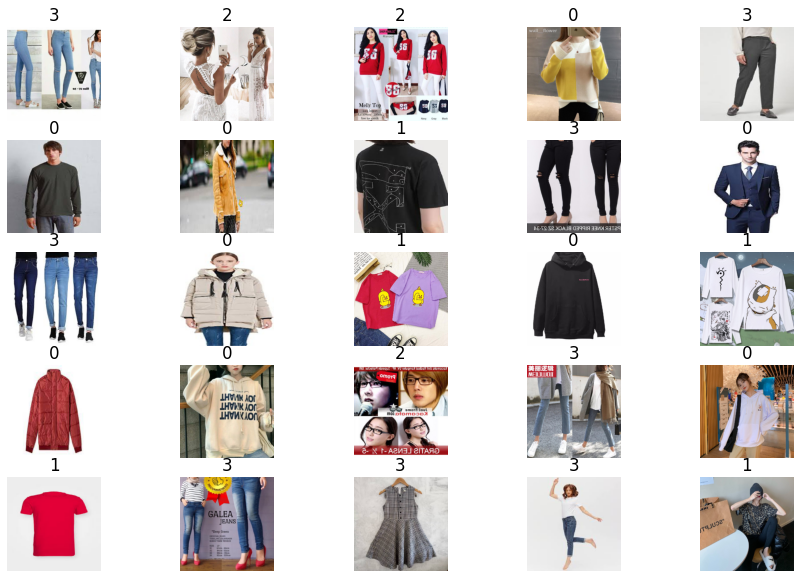

In [ ]:
a = train_generator.class_indices 
class_names = list(a.keys()) # storing class/breed names in a list 
  
def plot_images(img,labels): 
  plt.figure(figsize=[15,10]) 
  for i in range(25): 
    plt.subplot(5,5,i+1) 
    plt.imshow(img[i]) 
    plt.title(class_names[np.argmax(labels[i])]) 
    plt.axis('off') 

plot_images(x,y)

In [ ]:
# load the InceptionResNetV2 architecture with imagenet weights as base 
base_model = tf.keras.applications.InceptionResNetV2(
                     include_top=False,
                     weights='imagenet',
                     input_shape=(500,500,3))

base_model.trainable=False
"""
For freezing the layer, we make use of layer.trainable = False.
That means that its internal state will not change during training. 
model's trainable weights will not be updated during fit(), and also its state updates will not run.
"""
model = tf.keras.Sequential([  
        base_model,
        tf.keras.layers.Flatten(),
        # tf.keras.layers.BatchNormalization(renorm=True), 
        # tf.keras.layers.GlobalAveragePooling2D(), 
        # tf.keras.layers.Dense(512, activation='relu'), 
        # tf.keras.layers.Dense(256, activation='relu'), 
        tf.keras.layers.Dense(16, activation='relu'), 
        tf.keras.layers.BatchNormalization(renorm=True),
        tf.keras.layers.Dropout(0.5), 
        # tf.keras.layers.Dense(128, activation='relu'), 
        tf.keras.layers.Dense(4, activation='softmax')
    ])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),loss='categorical_crossentropy',metrics=['accuracy'])
"""
categorical cross entropy is taken since its used as a loss function for
multi-class classification problems where there are two or more output labels
using Adam optimizer for better performance
other optimizers such as sgd can also be used depending upon the model
"""

'\ncategorical cross entropy is taken since its used as a loss function for\nmulti-class classification problems where there are two or more output labels\nusing Adam optimizer for better performance\nother optimizers such as sgd can also be used depending upon the model\n'

In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 14, 14, 1536)     54336736  
 onal)                                                           
                                                                 
 flatten_4 (Flatten)         (None, 301056)            0         
                                                                 
 dense_26 (Dense)            (None, 16)                4816912   
                                                                 
 batch_normalization_2039 (B  (None, 16)               112       
 atchNormalization)                                              
                                                                 
 dropout_9 (Dropout)         (None, 16)                0         
                                                                 
 dense_27 (Dense)            (None, 4)                

In [ ]:
early = tf.keras.callbacks.EarlyStopping(patience=10, min_delta=0.001, restore_best_weights=True) 
# early stopping call back
# checkpointer = ModelCheckpoint(filepath='model.hdf5', verbose=1, save_best_only=True)

In [ ]:
batch_size=32
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size 
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size 

# fit model 
history = model.fit(train_generator,
              steps_per_epoch=STEP_SIZE_TRAIN, 
              validation_data=validation_generator, 
              validation_steps=STEP_SIZE_VALID, 
              epochs=25, 
              callbacks=[early])

In [ ]:
model.save("Model.h5")

Text(0.5, 1.0, '\nTraining and Validation Accuracy. \nTrain Accuracy: 0.9356142282485962\nValidation Accuracy: 0.8327850699424744')

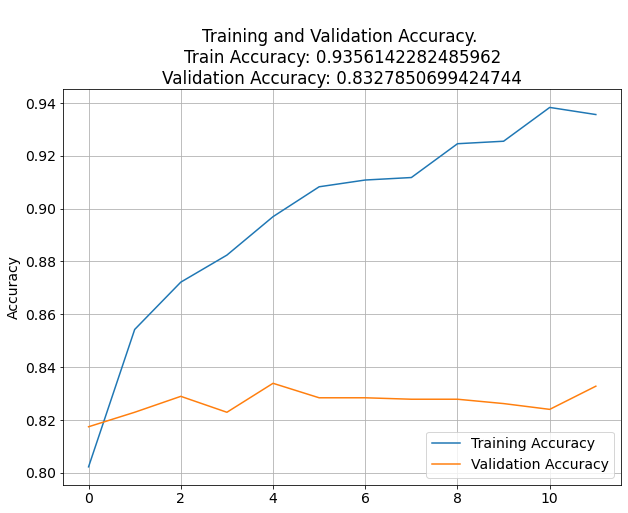

In [ ]:
# store results 
acc = history.history['accuracy'] 
val_acc = history.history['val_accuracy'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss'] 

# plot results 
# accuracy 
plt.figure(figsize=(10, 16)) 
plt.rcParams['figure.figsize'] = [16, 9] 
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1) 
plt.plot(acc, label='Training Accuracy') 
plt.plot(val_acc, label='Validation Accuracy') 
plt.legend(loc='lower right') 
plt.ylabel('Accuracy') 
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')

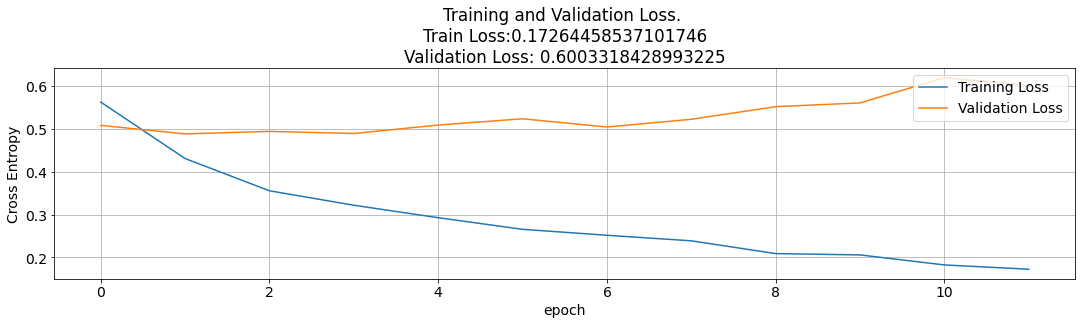

In [ ]:
# loss 
plt.subplot(2, 1, 2) 
plt.plot(loss, label='Training Loss') 
plt.plot(val_loss, label='Validation Loss') 
plt.legend(loc='upper right') 
plt.ylabel('Cross Entropy') 
plt.title(f'Training and Validation Loss. \nTrain Loss:{str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}') 
plt.xlabel('epoch') 
plt.tight_layout(pad=3.0) 
plt.show()

In [ ]:
accuracy_score = model.evaluate(validation_generator) 
print(accuracy_score) 
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100))   
print("Loss: ",accuracy_score[0])

58/58 [==============================] - 119s 2s/step - loss: 0.4887 - accuracy: 0.8248
[0.4887405335903168, 0.8247978687286377]
Accuracy: 82.4798%
Loss:  0.4887405335903168


In [ ]:
test_datagen = ImageDataGenerator(rescale = 1/.255)
test_generator = gen.flow_from_dataframe(
    dataframe = sample,
    directory = test_path,
    x_col = 'Name', 
    y_col = 'Type', 
    shuffle=False,)

Found 2800 validated image filenames belonging to 1 classes.


In [ ]:
pred = model.predict(test_generator)

In [ ]:
pred = np.argmax(pred, axis = 1)
pd.DataFrame(pred)

,0
0,3
1,1
2,0
3,0
4,0
...,...
2795,3
2796,2
2797,3
2798,1


In [ ]:
my_submission = pd.DataFrame({'Name': sample.Name, 'Type':  pred}) 
my_submission.to_csv('submission.csv', index=False) 
  
# Submission fie ouput 
print("Submission File: \n---------------\n") 
print(my_submission.head()) # Displaying first five predicted output

Submission File: 
---------------

                                   Name  Type
0  000d70d25191ad64f00ca88a227c5985.jpg     3
1  0030def9579a3cb2f5d334dee7a1fb78.jpg     1
2  00323f13dd4c931d2b98382318fff36f.jpg     0
3  0047247f1be33a5a0cee4470760dcdf7.jpg     0
4  006ef2a336bd15f53b50440837a847b2.jpg     0
